<a href="https://colab.research.google.com/github/GildasTaliah/QuantRiskManagement/blob/main/CreditScoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ANALYZING CREDIT SCORES WITH `tidymodels` in R**


In this brief project we will explore what differentiates credit score levels and demonstrate how dimensionality reduction can retain much of the information in a data while reducing its size. We'll use the 'embed' and 'tidymodels' to build **UMAP** and tree models.  We will essentially be applying methods of data science and machine learning to solve a credit scoring problem for a global finance company.

## **Setup Environment**

We begin with loading the necessary packages - `tidyverse`, `tidymodels` and `embed`. We define them briefly as follows:

- [`tidymodels`](https://www.tidymodels.org/) : next generation of packages that incorparates `tidyverse` principles into machine learning and modelling.
- [`embed`](https://embed.tidymodels.org/) :  contains extra recipe steps to create "embeddings" such as encoding predictors.   


In addition, we also install `randomForest` and `xgboost` engines, to make use of the model's algorithm. Also `rpart` and  `vip`will be included for visualization purposes.
  

In [1]:
# Install packages
install.packages(c("tidymodels", "randomForest", "xgboost", "embed"))
install.packages(c("rpart.plot", "vip"))

# Load main packages
library(tidyverse)
library(tidymodels)
library(embed)

# Load other Engines
#library(rpart)
library(randomForest)
library(xgboost)

# set options to enlarge plots
options(repr.plot.width=20, repr.plot.height=20)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘warp’, ‘future.apply’, ‘iterators’, ‘listenv’, ‘parallelly’, ‘lhs’, ‘RcppEigen’, ‘BH’, ‘sitmo’, ‘DiceDesign’, ‘sfd’, ‘sparsevctrs’, ‘patchwork’, ‘globals’, ‘clock’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘doFuture’, ‘foreach’, ‘future’, ‘GPfit’, ‘modelenv’, ‘FNN’, ‘irlba’, ‘RcppAnnoy’, ‘RSpectra’, ‘dqrng’, ‘RcppProgress’, ‘dials’, ‘hardhat’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’, ‘uwot’


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.

## **Load Credit Data**


Presumably, the finance company has collected data on basic bank details which are credit related information. Apparently management wants to build an intelligent system to segregate the clients into credit score brackets so as to reduce the manual effort associated with that.

Essentially, with the provided credit score data, we want to build machine learning models that can classify the credit scores effectively, even with unseen data.

The data was adapted from [kaggle](https://www.kaggle.com/datasets/parisrohan/credit-score-classification)


Below we start by loading the data using the read_csv() function from `tidyverse` and take a glimpse of it.  

In [2]:
# url of credit score data
url <- "https://assets.datacamp.com/production/repositories/6081/datasets/e02471e553bc28edddc1fe862666d36e04daed80/credit_score.csv"

# Read data into dataframe
credit_df <- read_csv(url)

# Reorder the credit score factor levels
credit_df <- credit_df |>
          mutate(credit_score = factor(credit_score, levels = c("Poor", "Standard", "Good")))

# convert other character features to categorical/factor variables
credit_df <- credit_df |>
          mutate(across(where(is.character), \(x) as.factor(x)))

# Loak at labels and features
glimpse(credit_df)

Rows: 18965 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): month, occupation, credit_mix, payment_of_min_amount, payment_beha...
dbl (17): age, annual_income, monthly_inhand_salary, num_bank_accounts, num_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 18,965
Columns: 23
$ month                    <fct> January, July, April, January, February, May,…
$ age                      <dbl> 44, 19, 39, 43, 22, 52, 32, 45, 37, 22, 26, 2…
$ occupation               <fct> Doctor, Doctor, Manager, Developer, Developer…
$ annual_income            <dbl> 32625.590, 31041.460, 25876.180, 15928.750, 1…
$ monthly_inhand_salary    <dbl> 2922.7992, 2501.7883, 2293.3483, 1301.3958, 1…
$ num_bank_accounts        <dbl> 0, 5, 4, 9, 7, 5, 7, 9, 1, 7, 5, 7, 9, 4, 4, …
$ num_credit_card          <dbl> 5, 2, 6, 9, 9, 5, 8, 8, 5, 7, 5, 5, 5, 5, 7, …
$ interest_rate            <dbl> 8, 5, 7, 24, 18, 5, 26, 21, 10, 25, 3, 23, 32…
$ num_of_loan              <dbl> 4, 1, 3, 4, 2, 4, 9, 2, 2, 7, 1, 3, 6, 1, 2, …
$ delay_from_due_date      <dbl> 5, 5, 5, 26, 40, 23, 62, 18, 13, 51, 10, 15, …
$ num_of_delayed_payment   <dbl> 10, 11, 15, 22, 17, 1, 18, 18, 3, 16, 7, 21, …
$ changed_credit_limit     <dbl> 2.55, 5.13, 10.29, 1.26, 6.09, 0.75, 22.13, 8…
$ num_credit_in

The credit data has 22 features and one target variable.

The target variable - `credit score` is categorical and has three levels: **Poor, Standard and Good**.

In line with management goals, our objective to is to train  machine learning models capable of differentiating between poor, standard and good credit scores and hence accurately predict the credit score class of a client given their bank details.

The modelling will further enable us explain why consumers' credit score differ. Additionally, we will learn about a feature extraction algorithm UMAP and use it within the tidymodels framework.

## **Exploration**

Below we take a look at credit_df a little more and then see how we can further understand why consumers have diffrent credit scores.

> It's imperative to know that as humans we can't visualize high-dimensional data, for we are limited to three dimensions (maybe four, if we can add animation to capture time).

**What predictors impact credit scores the most?**

In [3]:
# view summary
summary(credit_df)

     month           age               occupation    annual_income     
 August :2409   Min.   :18.00   _______     : 1366   Min.   :    7006  
 June   :2403   1st Qu.:26.00   Teacher     : 1243   1st Qu.:   19609  
 March  :2389   Median :34.00   Mechanic    : 1230   Median :   38431  
 April  :2378   Mean   :34.48   Engineer    : 1216   Mean   :  192905  
 January:2361   3rd Qu.:42.00   Architect   : 1214   3rd Qu.:   75724  
 July   :2351   Max.   :56.00   Entrepreneur: 1204   Max.   :24177153  
 (Other):4674                   (Other)     :11492                     
 monthly_inhand_salary num_bank_accounts num_credit_card   interest_rate    
 Min.   :  303.6       Min.   :  -1.00   Min.   :   0.00   Min.   :   1.00  
 1st Qu.: 1635.8       1st Qu.:   3.00   1st Qu.:   4.00   1st Qu.:   6.00  
 Median : 3167.7       Median :   5.00   Median :   6.00   Median :  11.00  
 Mean   : 4338.2       Mean   :  16.15   Mean   :  23.49   Mean   :  70.91  
 3rd Qu.: 6137.8       3rd Qu.:   8.00 

Displayed summary tells us a lot about each variable. Regarding **month**, we noticed just a few months are present and the whole lot of the observations classified as others. This could impact modelling in that; some amount of information may be lost.

**Age** depicts oldest and and youngest clients are 56 and 18 respectively, with median age 34 years old. **Occupation**, **credit mix**, **payment_behaviuor**  too suffer from incorrectly reported or keyed in data as is the feature - **month**.  



  **Please Note**
 The data seems to suffer from some inaccuracies. However, we will model the data this way and next time a proper data cleaning cleaning technique will be implemented. But well we will ensure the data is in a state where the models can understand e.g converting categorical data to dummy variables where necessary.

**Annual Income Density**

We look at the distribution plot of annual income for each of the three credit score levels.

Warning message:
“Removed 199 rows containing non-finite outside the scale range
(`stat_density()`).”


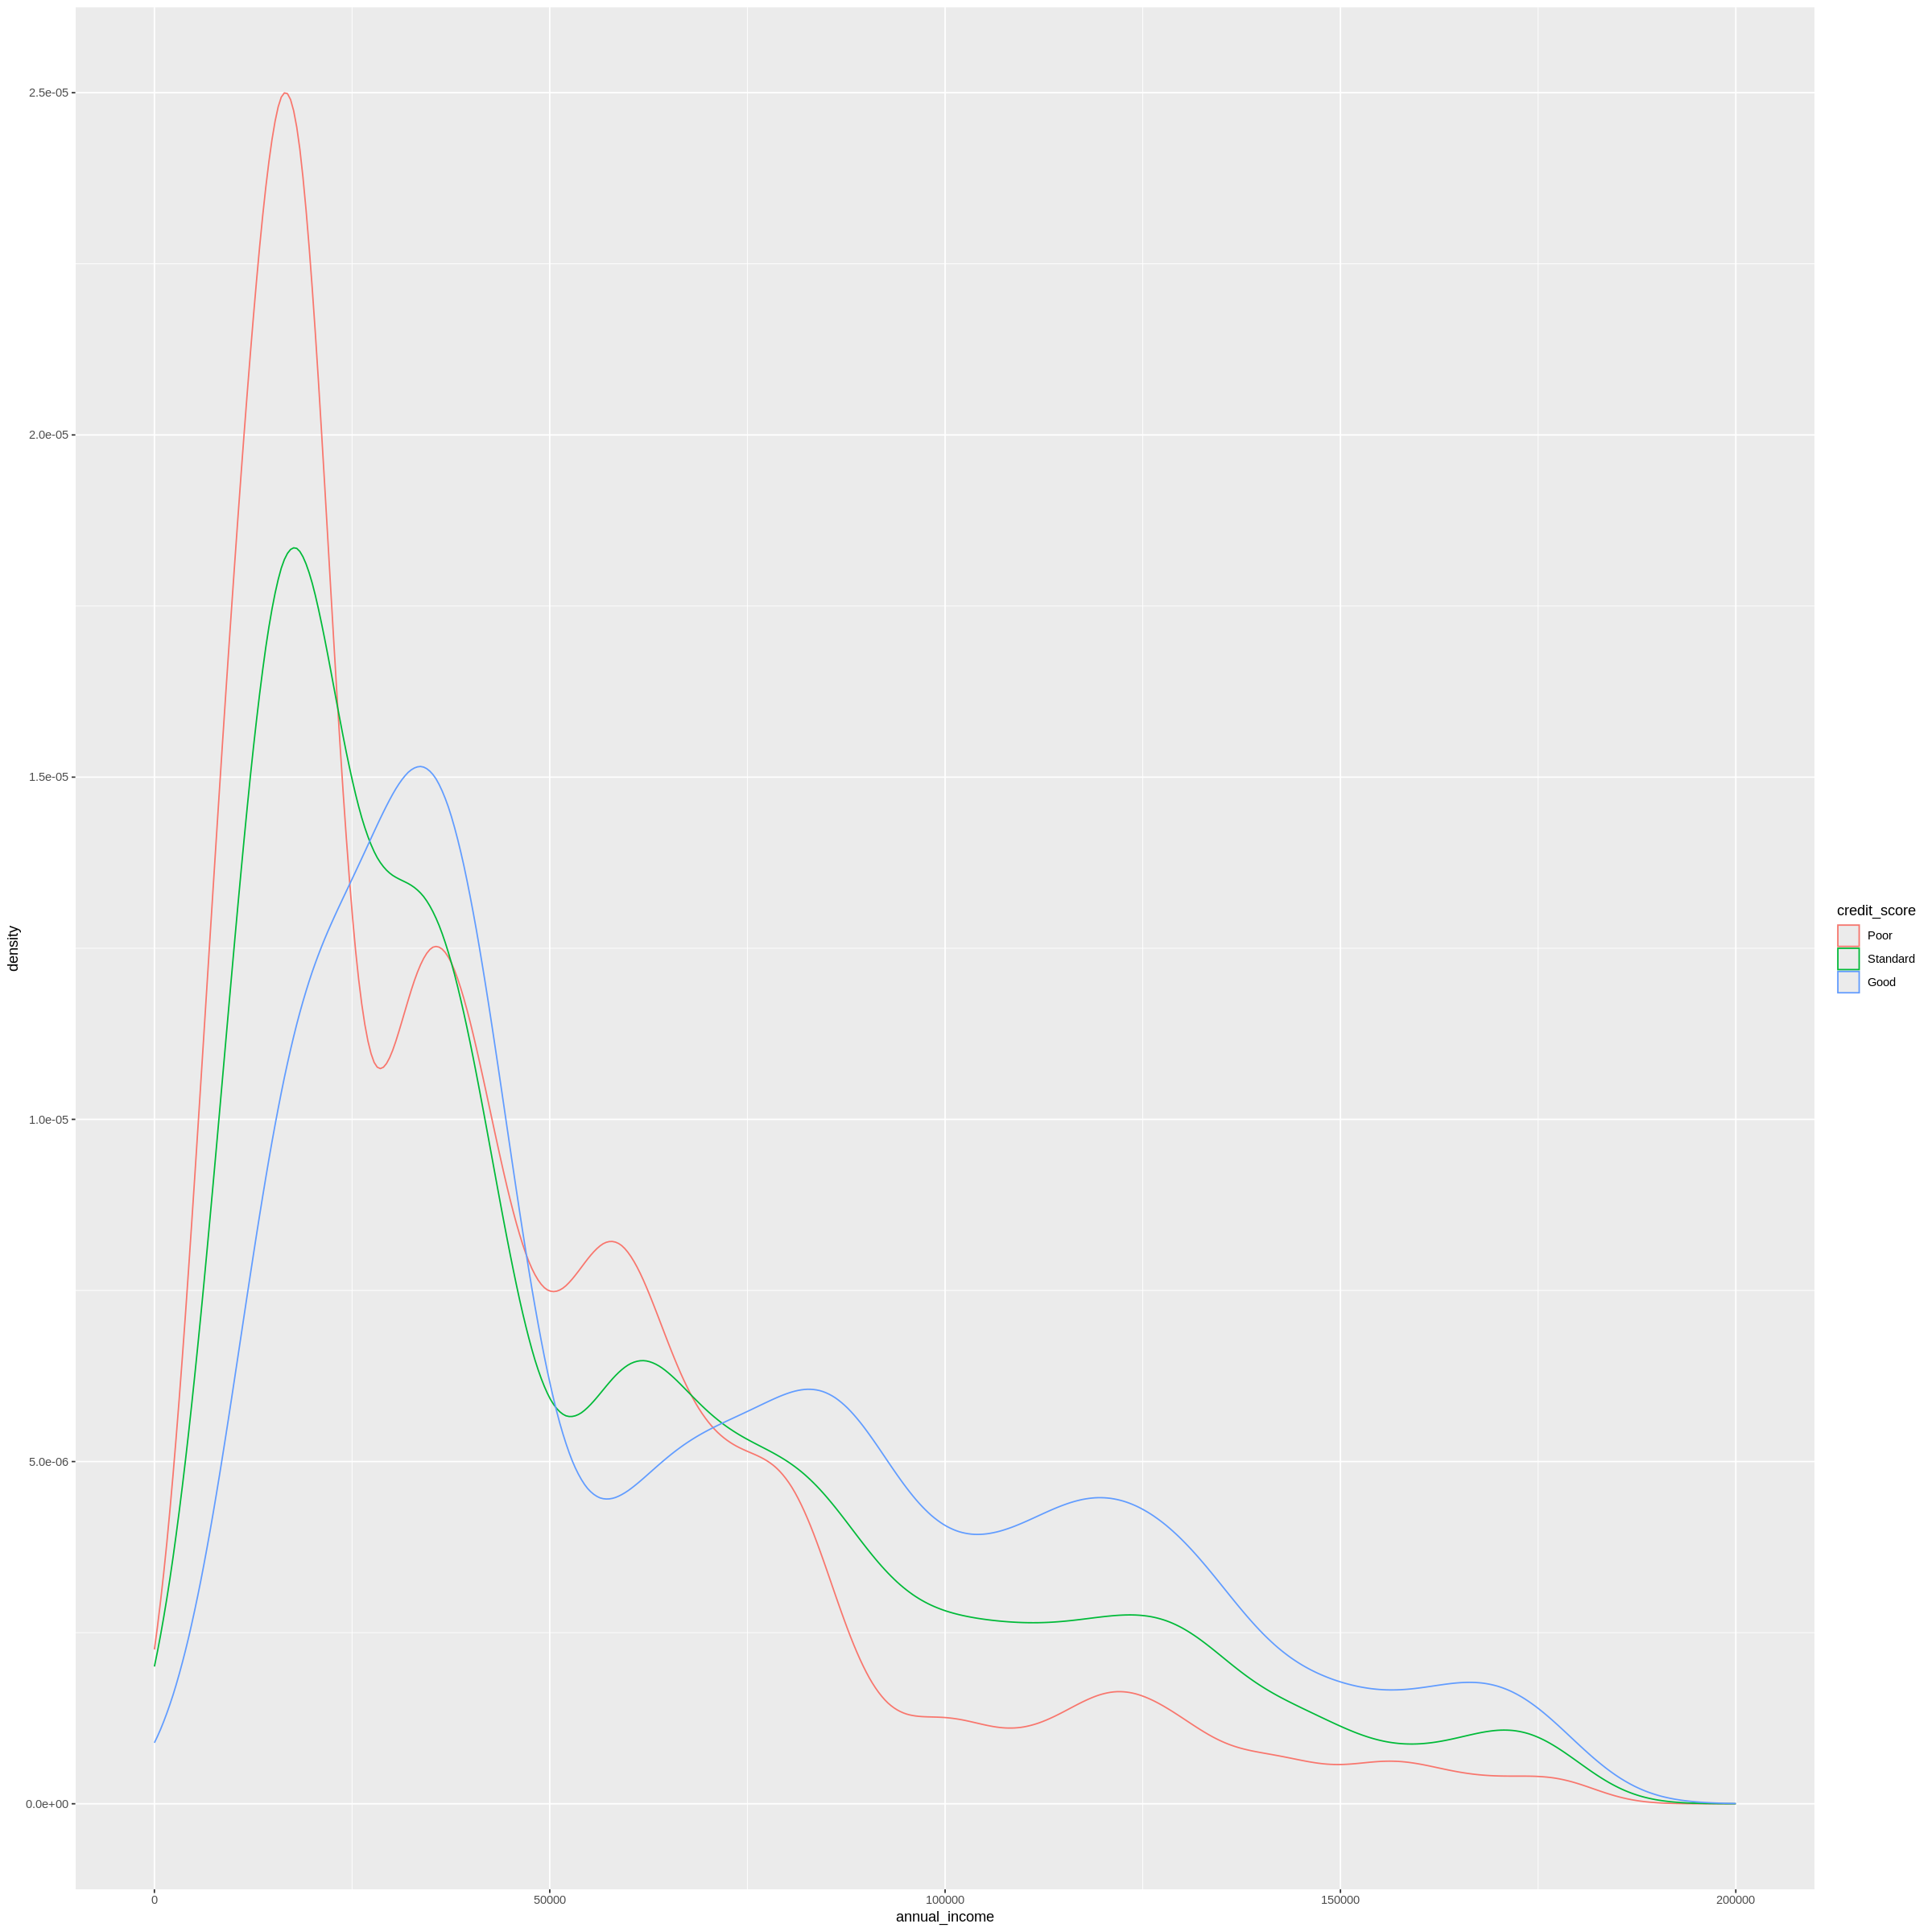

In [4]:
# plot annual income for each credit score level
credit_df |>
  ggplot(aes(x = annual_income, color = credit_score )) +
  geom_density() +
  xlim(0, 200000)


> **Takeaway**: Most of those with lower annual income tend to have poorer credit scores, also as the income levels increases towards 200,000 more clients are associated with with good credit scores compared to other credit levels. This demonstrate there exist some relationship between credit scores and annual income.   

**Age density plot**

Below we look at the age distribution plot for each of the three credit scores level.

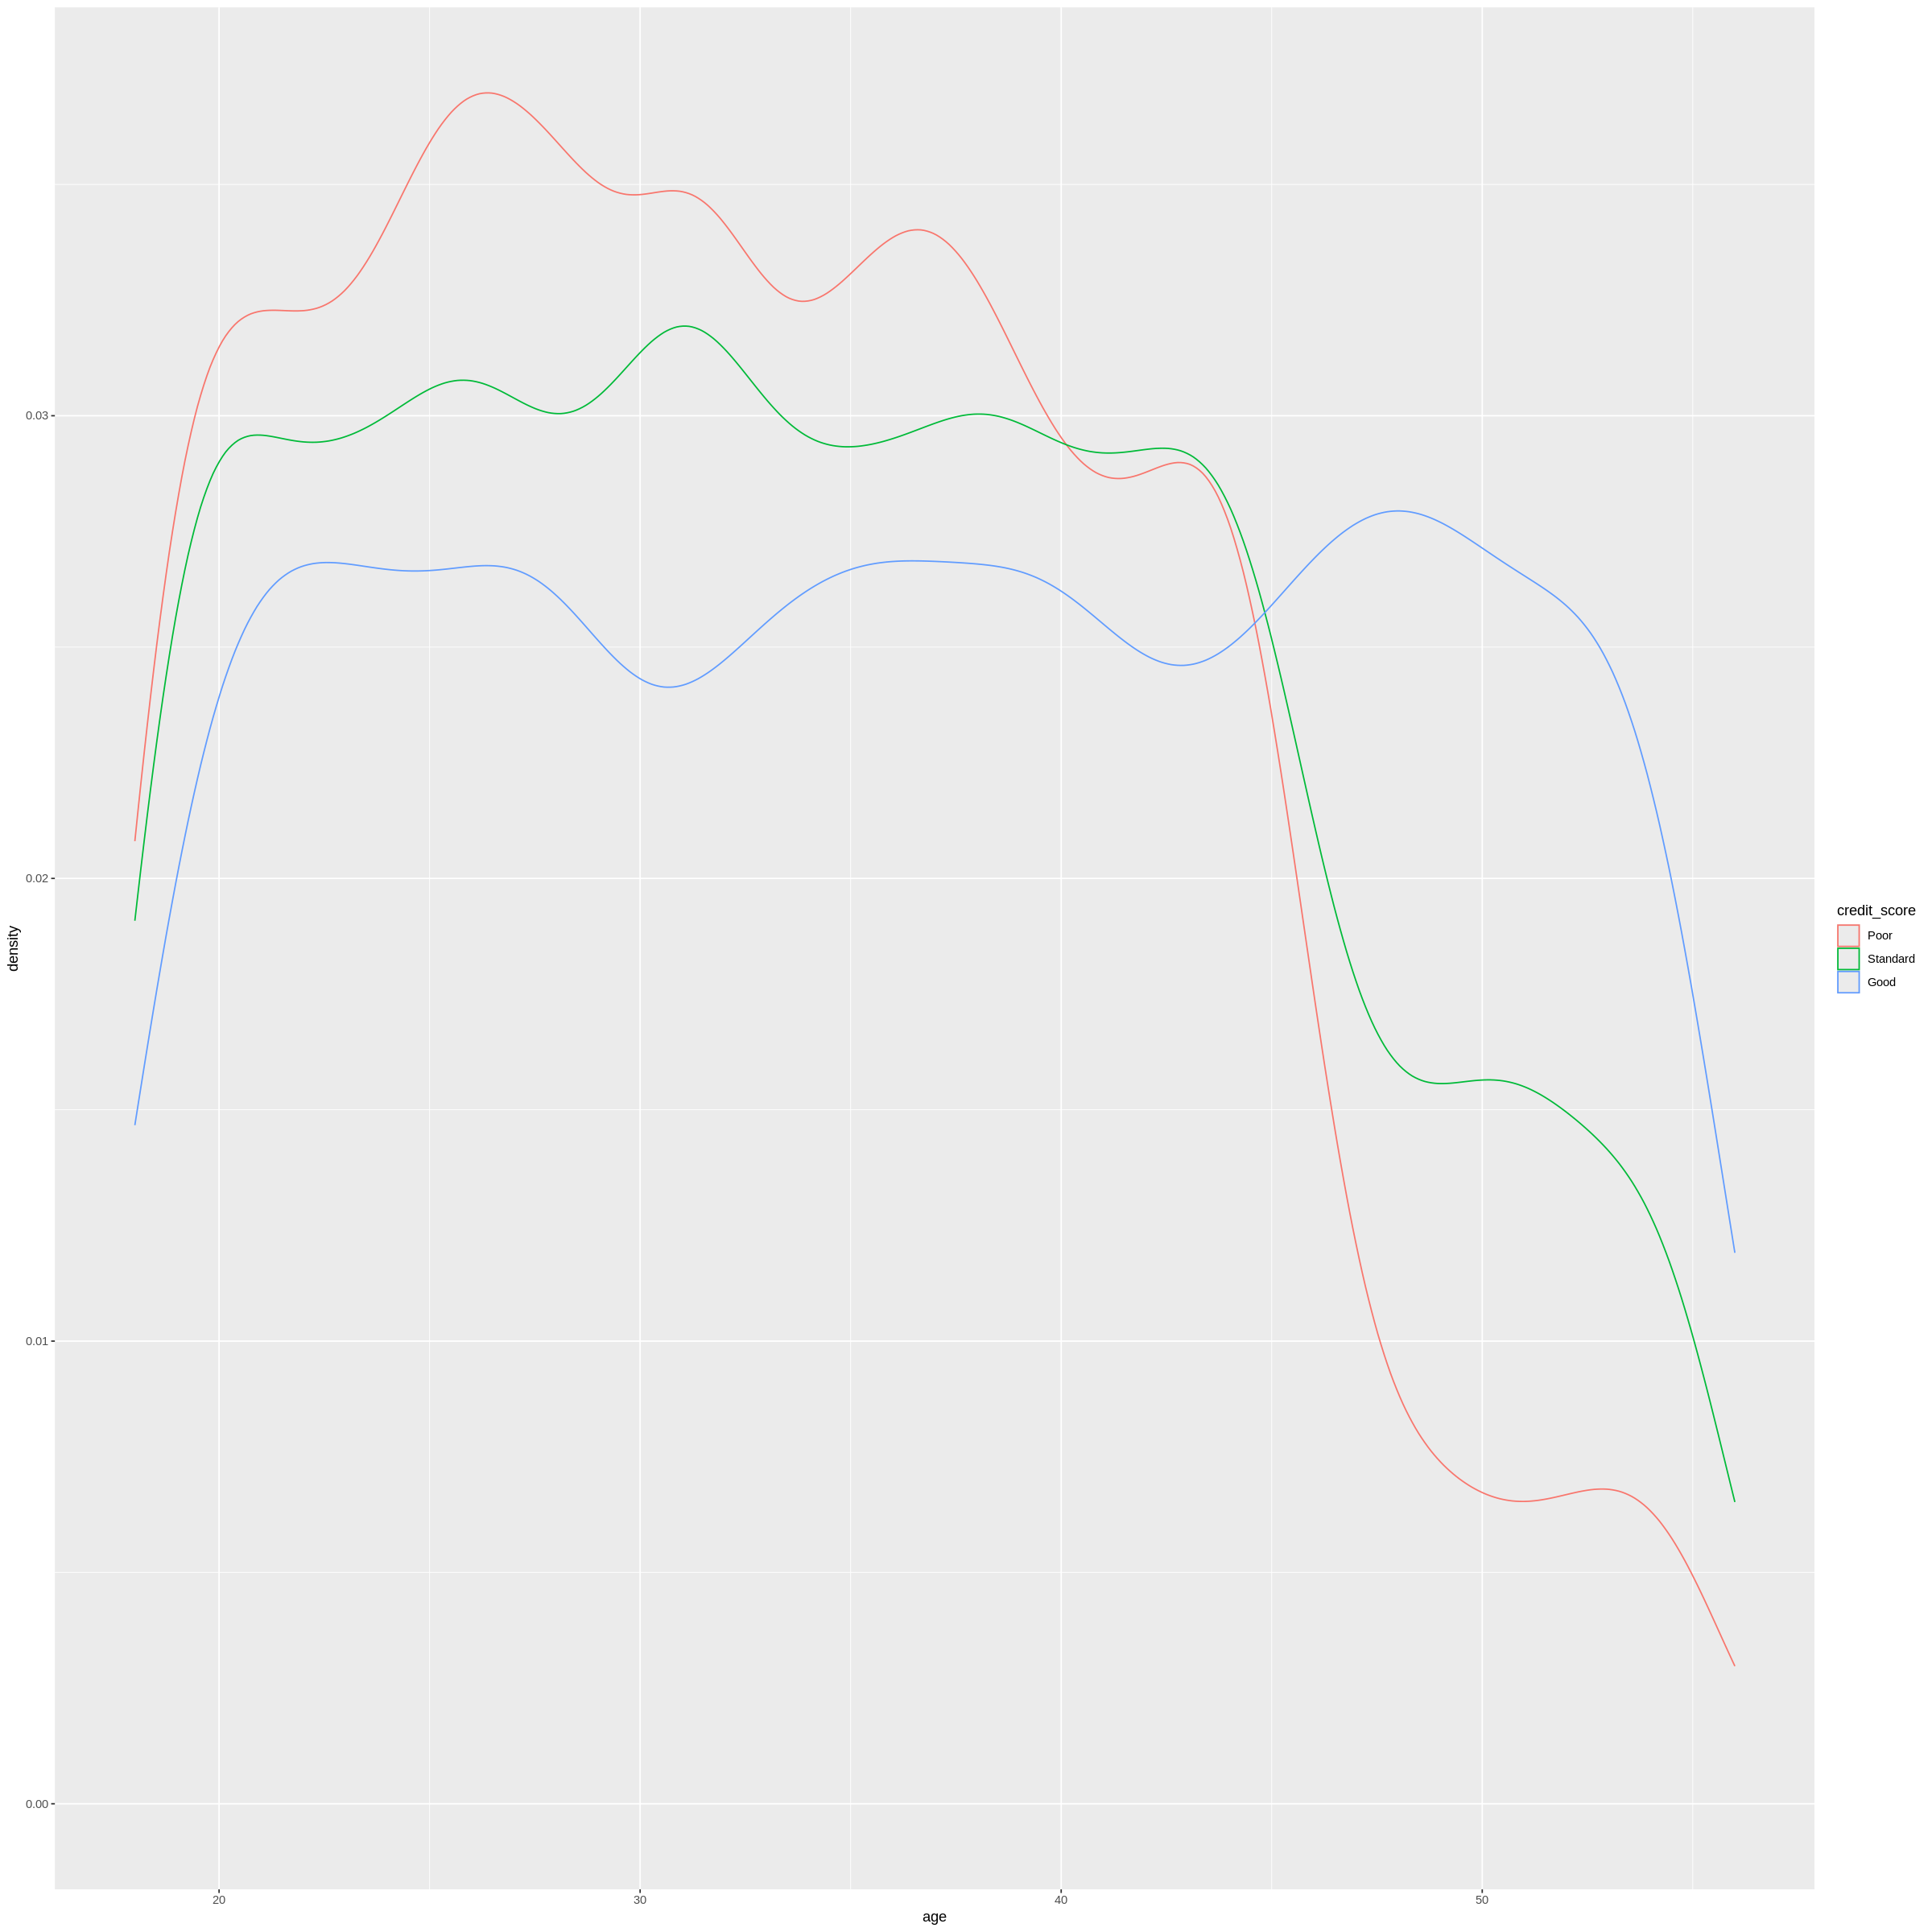

In [5]:
# plot age distributions for each credit score level
credit_df |> ggplot(aes(x = age, color = credit_score)) +
             geom_density()

> **Takeaway**: Most clients of the ages 20 to 40 thereabout are associated with poorer credit scores, on the other hand most older clients (of age 45 and above) are associated with good credit scores. Thus, age would be a determinant of a clients credit scores.

**Credit utilization ratio vs number of credit cards**

- Credit utilization = the amount of their credit limit the consumer has used:

$$\text{credit  utilization ratio}= \frac{credit \, \, balance}{credit \, \, limit}$$

Below we explore the credit utilization ratio and the number of credit cards a consumer has with a scatterplot.



Warning message:
“Removed 967 rows containing missing values or values outside the scale range
(`geom_point()`).”


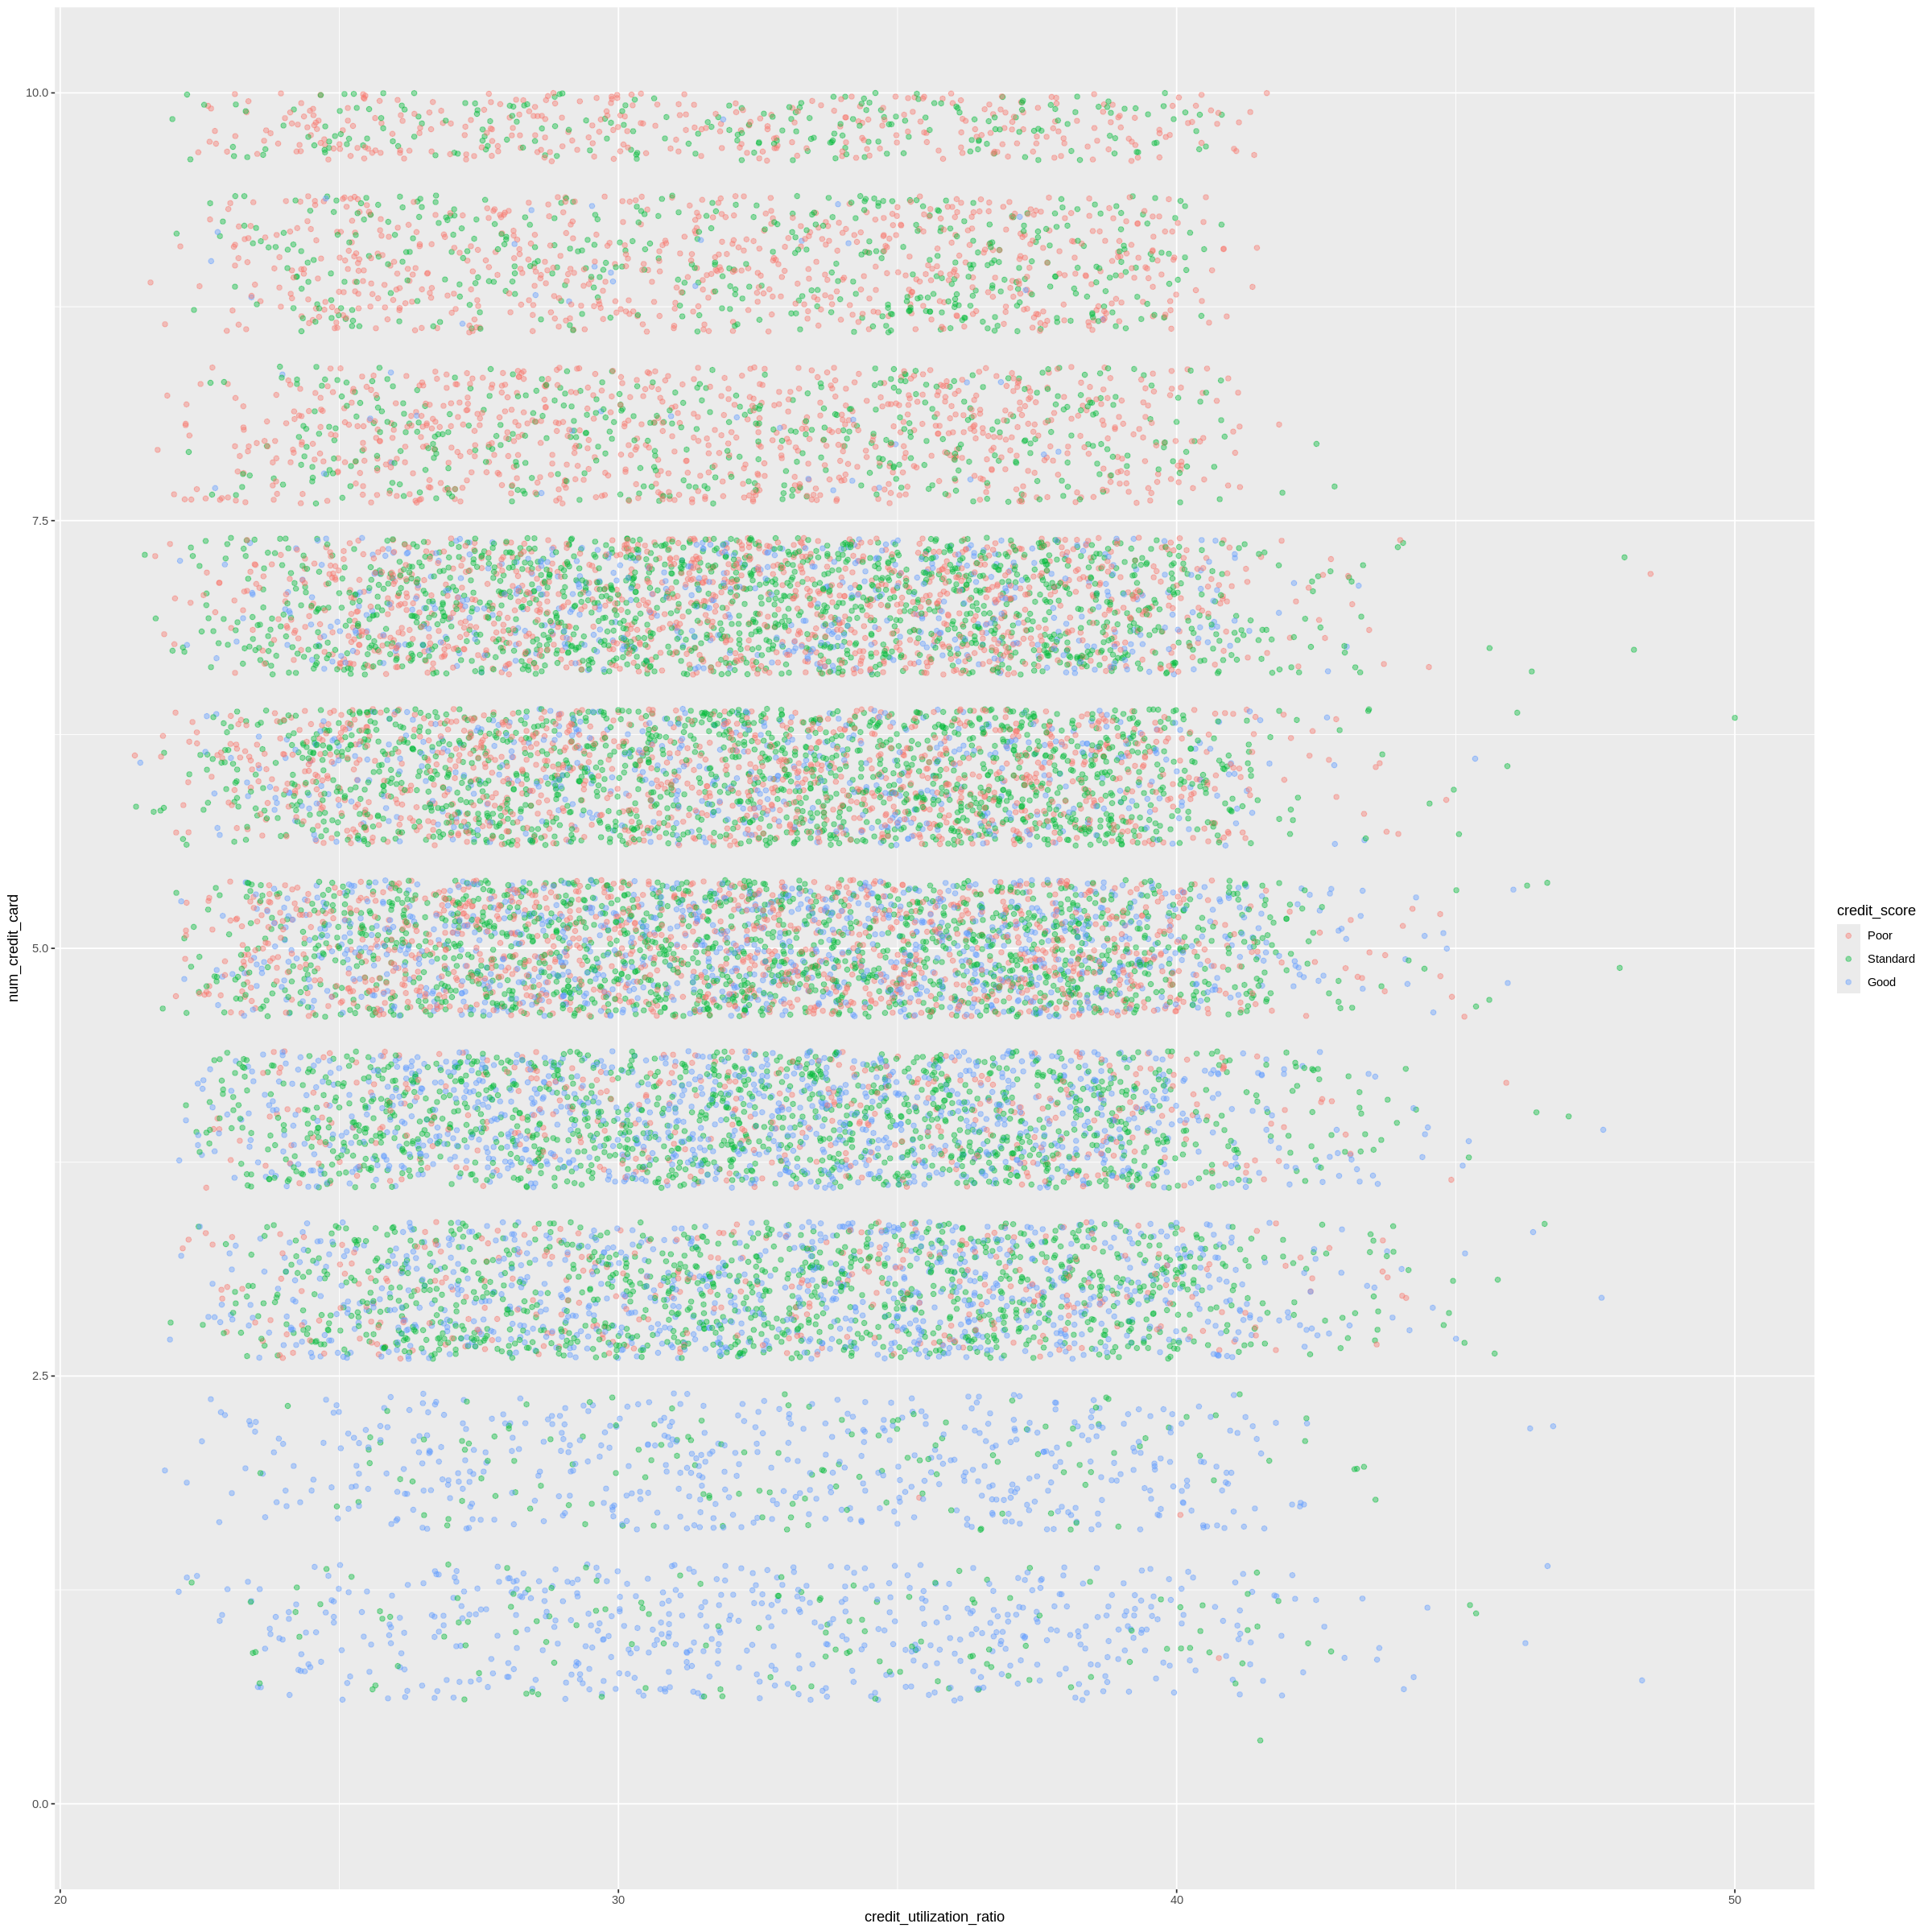

In [6]:
# plot credit utilization ratio vs num credit card
credit_df |>
  ggplot(aes(x = credit_utilization_ratio, y = num_credit_card, color = credit_score)) +
  geom_jitter(alpha = 0.4) +
  ylim(0, 10)

> The number of credit cards separates the consumers' credit levels pretty well. Not surprisingly, those with more credit cards tend to have poorer credit. Thus, `num_credit_card`could be useful in determining credit scores.

Going through each or visiting every combination of the predictors to determine which predictors help distinguish information about consumers credit levels would be time consuming, almost a different ball game on it's own. Through that, however, we'd discover that some predictors contain insignificant information pertaining to clients credit levels. As a result dropping would improve overall performance.


Dimensionality reduction is all about eliminating the noise and honing in on the signal, this helps us accomplish our goal in predicting the target variable. Principal Component Analysis (PCA) is one vital technique in this regards, but in here we utilize a different technique suitable for features with non-linear relationship, known as - UMAP.

# **UMAP**

UMAP (Uniform Manifold Approximation and Projection) just like Principal Component Analysis (PCA) is a feature extraction technique. We will use it to reduce our 22 predicting features (dimensions) down to 2 dimensions, while still keeping as much of the original information as possible. We'll later demonstrate how much information was retained by fitting tree models to predict score level on both the raw data and the UMAP transformed data, then proceed to observe the performance difference.

**Create the `tidymodels` recipe**


A recipe in `tidymodels` is a series of steps we apply to the data to get a predictable, repeatable and desired outcome.

The UMAP recipe will have the following steps:

- `step normailze()` will be applied only to numeric data predictors as we can't normalize categorical data. Normalize ensures that unequal ranges of the features will not have unequal leverage in determining their importance in credit score levels.
- We apply `step_umap()` to all the predictors, but not the target variable because we need to keep that separate to train the model - UMAP can handle both continuous and categorical data types.
- We proceed to speicify the target variable with the **outcome** - `outcome = vars(credit_score)` argument.
- Lastly we specify tha we want to reduce the data to 2 dimensions with `num_comp`  in `step_umap()`

> Note that with tidymodels, the preprocessing steps are  applied to test data as well, this is the case when we use either of augment() or predict() function. This behaviour can be disabled by setting step_*(..., skip=TRUE).  See more --> [Link](https://www.tmwr.org/recipes.html)

In [7]:
# create the UMAP recipe with the normalize and UMAP steps
umap_recipe <- recipe(credit_score ~ ., data = credit_df) |>
               step_normalize(all_numeric_predictors()) |>
               step_umap(all_predictors(), outcome= vars(credit_score), num_comp = 2)

**Train the recipe, then extract and plot the data**

Now we proceed to apply the recipe, from there we extract the transformed data so we can plot it.

The `prep()` function *trains* the recipe on the data. Put it simply, it applies the UMAP algorithm to the data.

Afterwards we use the `juice()` to extract the UMAP transformed data from the recipe, then later plot it.

In [8]:
# prepare (train) the recipe and juice(extract) the transformed data
umap_credit_df <- umap_recipe |>
                  prep() |>
                  juice()


Before plotting the data, let us take a glimpse of it. Notice the two UMAP dimensions - implying data reduction effective.

In [9]:
glimpse(umap_credit_df)

Rows: 18,965
Columns: 3
$ credit_score <fct> Standard, Good, Standard, Poor, Poor, Poor, Standard, Poo…
$ UMAP1        <dbl> -1.0518286, -3.9421337, -2.1769209, -5.4380050, -6.220437…
$ UMAP2        <dbl> -2.7147012, -8.6824026, -1.2895217, 8.7086859, 8.8598394,…


**Plot the UMAP dimensions**

Ultimately UMAP is most useful for visualizing high dimensional data. Below we basically plot the two deimensions and colour code the credit levels. Notice how well the UMAP transformation separates the credit score levels.  

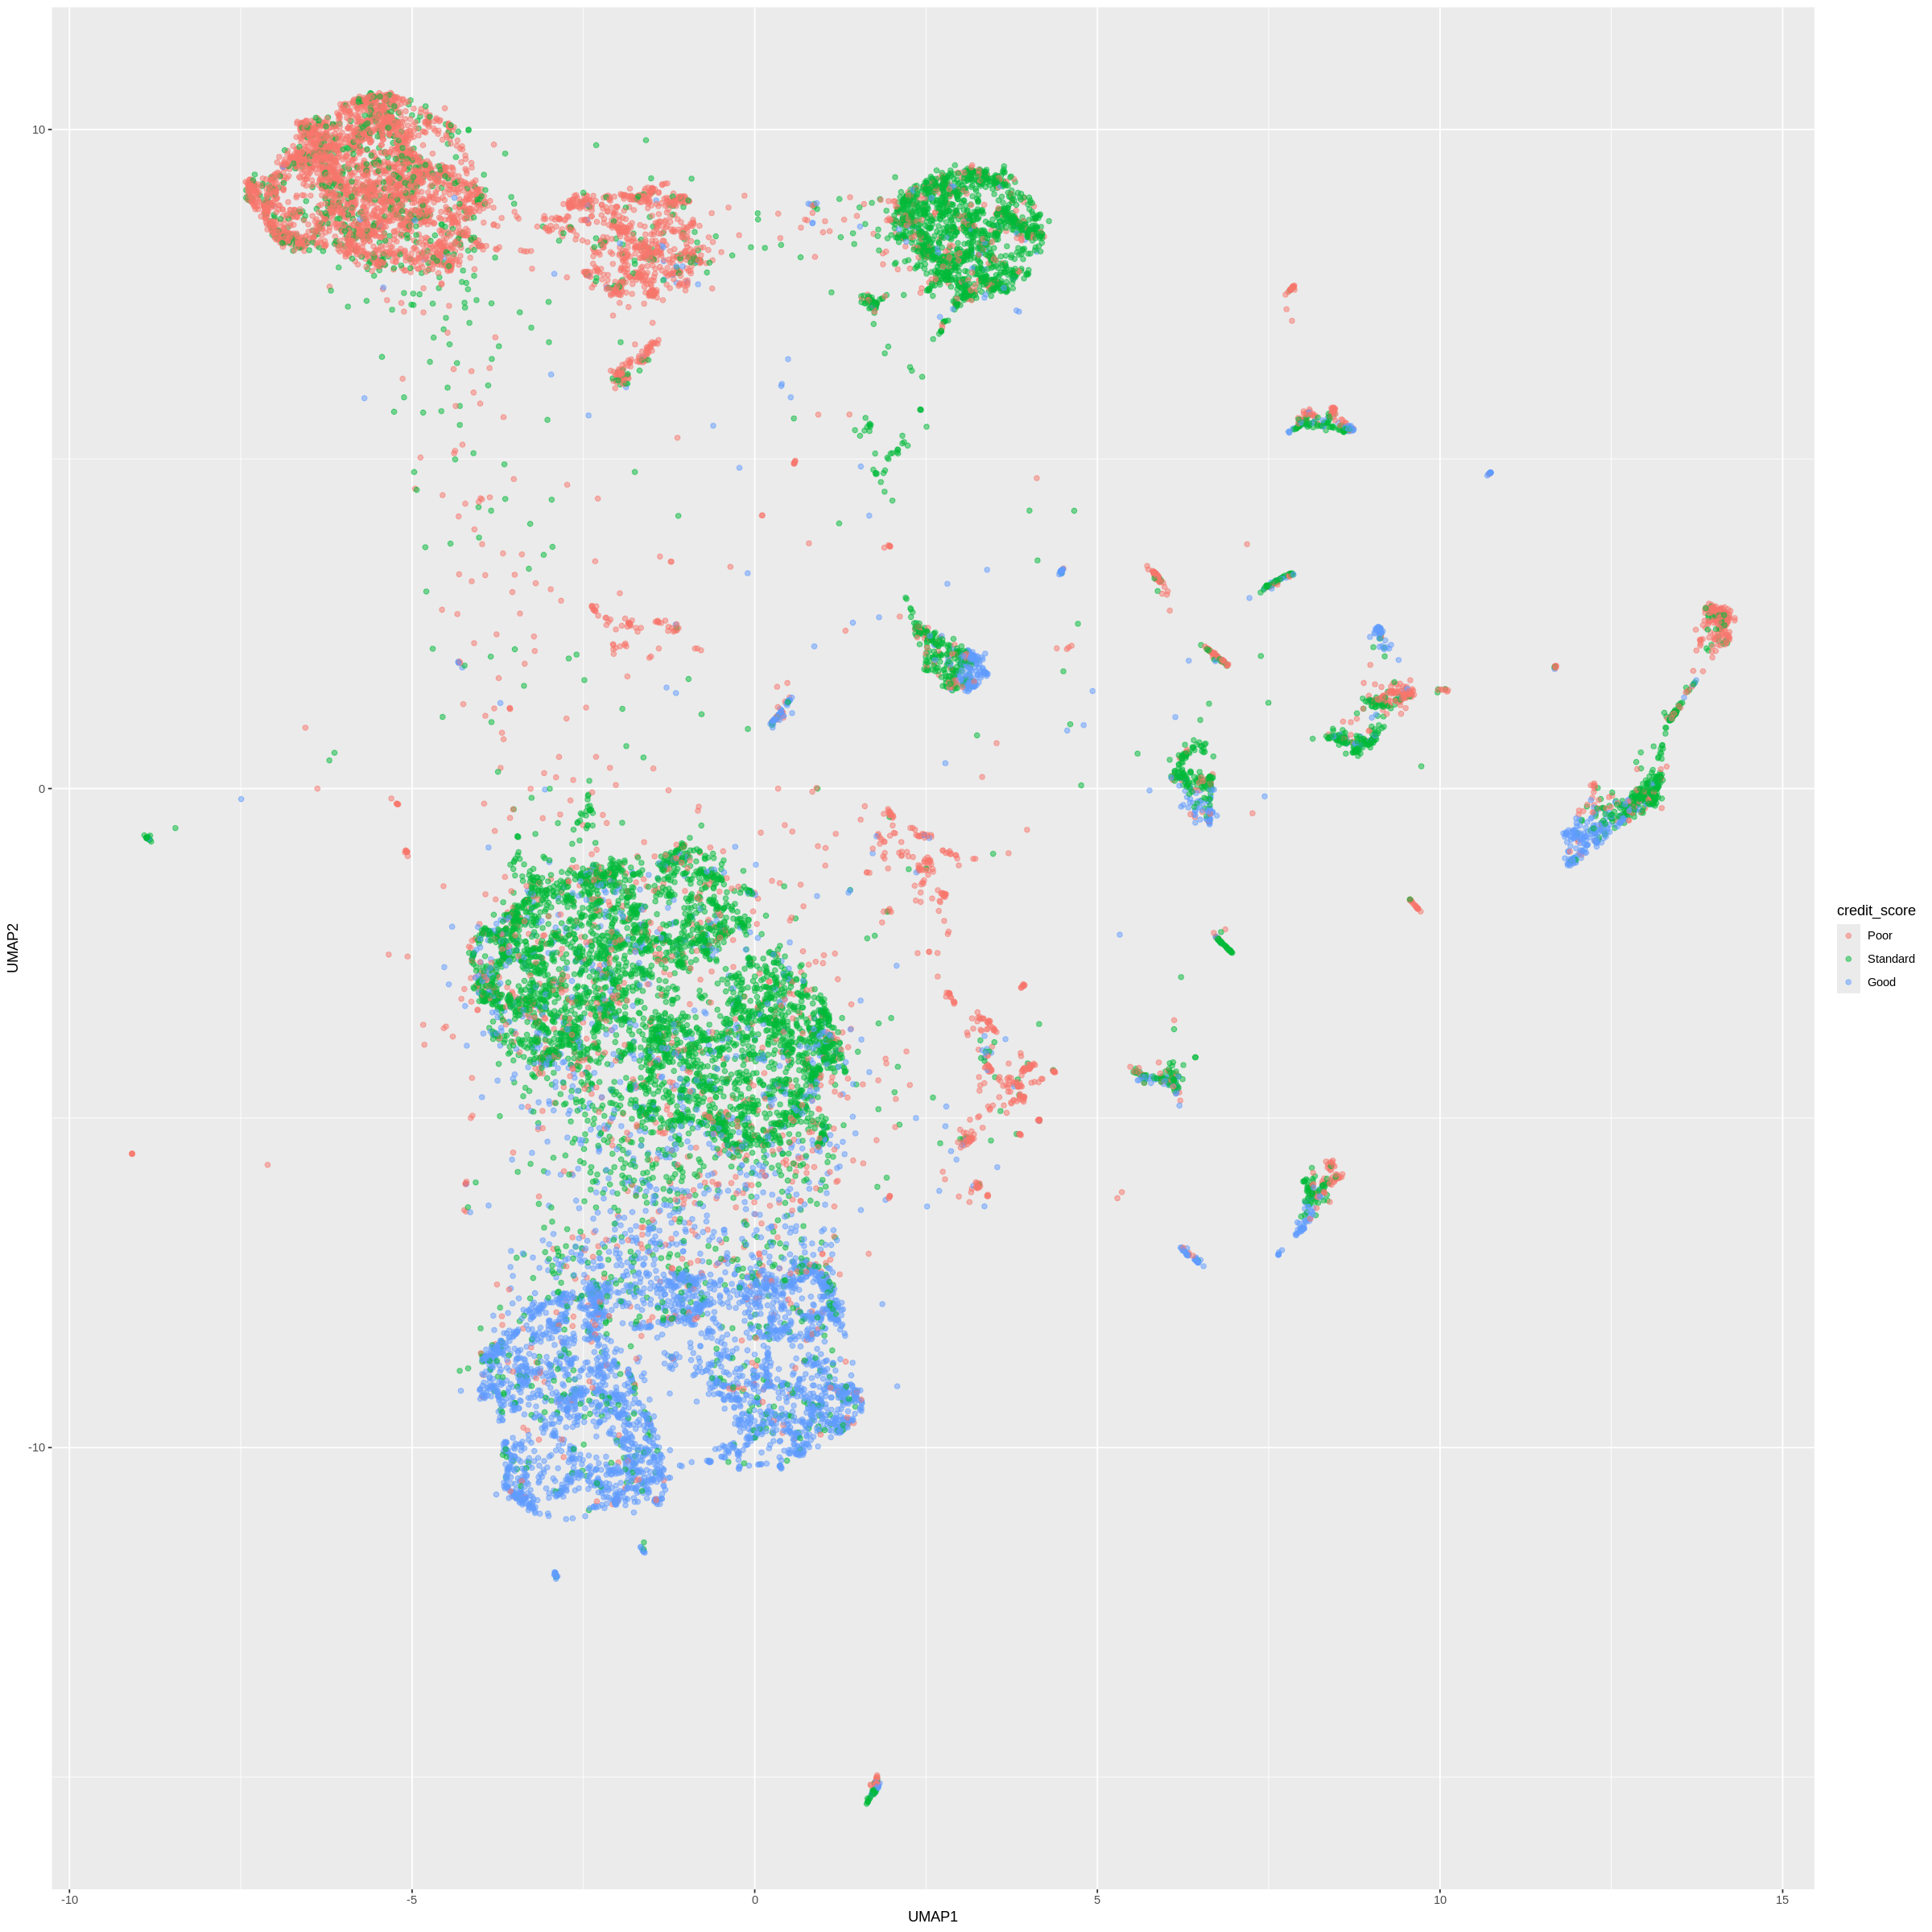

In [10]:
# create a scatter plot of the UMAP dimensions, colouring credit score level
umap_credit_df |>
  ggplot(aes(x= UMAP1, y= UMAP2, color = credit_score)) +
  geom_point(alpha= 0.5)

We can observe from the diagram above, how well the UMAP has distinguished between the credit score levels.

We notice most of the `Poor` rated customers are **north west** of the frame, whilst the `Standard` are mostly at the **centre west**, another chunk of `Standard`slightly **center east** from the centre,   `Good`rated clients are however, are mostly clustered at  **south west** of the frame and a some few points from each credit level are just randomly scattered around the frame.


A very important question to ask: How did it separate the credit scores? essentially, what does `UMAP1` and `UMAP2` mean ?

Well this is the downside of feature extraction technique such as PCA and UMAP - the extracted dimensions are often difficult to interpret.

# **Building UMAP into Machine Learning Model**

Now, let's turn our attention to integrating dimensionality reduction into `tidymodels` workflow. In this training, we do this to illustrate the concept of information and that UMAP (like other feature extraction techniques), foundationally, seeks to retain  most information in the data while significantly reducing the dimension.

**What makes UMAP different from PCA?**

- **PCA** is a linear method that finds the principal components, which are orthogonal vectors that capture the most variance in the data, **UMAP** on the otherhand is a non-linear method that aims to approximate the underlying manifold structure of the data.

- PCA preserves global variance, while UMAP focuses on local distances and relationships

- UMAP is often preferred when we want to visualize data and preserve the local structure, especially in high-dimensional datasets whereas PCA is well-suited for large datasets and situations where linear relationships are dominant.


We will build classification models **with** and **without** UMAP and compare their performance. The idea is that if UMAP cuts too much information, the classfication moel's performance will take a big hit.

Now, let's create the train and test sets. The splitting will be done 75% to 25%, while we set seed to 75 for reproducibility. The number 75 is of course just arbitrary.

In [11]:
# set seed to make this reproducible
set.seed(75)

# Initialize the data split
credit_split <-  initial_split(credit_df)

# Extract the train dataset
train <- training(credit_split)

# Extract the test dataset
test <-  testing(credit_split)

In [12]:
# set seed to make results reproducible
set.seed(75)

# initialize the data split
credit_split <- initial_split(credit_df, prop = 3/4, strata = 'credit_score')

# extract the train dataset
train <- training(credit_split)

# extract test
test <- testing(credit_split)

## **Machine Learning Models**

Machine Learning (ML) leverages large datasets and computational power to enhance task such as predictive modelling/analytics, trading strategies, fraud detection, credit scoring, asset pricing, portfolio allocation, risk management etc. In this project we consider three three ML models namely: Decision tree (dt) model, random forest (rf) model and eXtreme Gradient Boosting (xgb) model.

### **Decision Tree Model**



A Decision Tree is a supervised machine learning algorithm that splits data into branches based on feature conditions, forming a hierarchical tree-like structure. The model learns and improves predictive accuracy by recursively selecting  optimal splits the data at optimal points.

-  Importantly, decision trees splitting  do not require feature scaling, as their splitting criteria are based on raw feature values rather than distance metrics. Thus, no data scaling of some sort (standardization, normalization) will be necessary.

### **Random Forest Model**

Random Forest combines the predictions made by **multiple decision trees** and returns a single outcome. Through a technique known as **bagging or boostrap aggregation**, the model leverages the capabilities of multiple decision trees. For classification the outcome is the **majority class prediction**.


### **eXtreme Gradient Boosting Model**

xgb employs gradient boosting, a technique that sequentially builds models (uses decision trees as its base learners), with each new model focusing on correcting the errors of the previuos model.





## **Build `tidymodels` workflow without UMAP**
Now, it's time to build the base model - the model from the original `credit_df` data, without using UMAP.

A `tidymodels` workflow allows us to bundle recipe code with model building code -- it's a pipeline for pre-processing, modeling, and post-processing.

So, let's create the recipe and the model, then proceed to bundle them into a worflow object.

**Create the recipe**


For the tree model case, it will be an empty recipe - for tree models no modification (scaling) of the the original `credit_df` data will be required. Notice that we pass the recipe object a formula -- this basically says, "Use `credit_score` as the target variable", the `~` implies we use all other existing variables as features.

For the boosting model, we have to convert categorical data types to dummy as boosting model requires only numeric since it utilizes vectorized computations and matrix operations in the background.

In [13]:
# create an empty recipe object with credit_score as the target variable
# tree recipe
tree_recipe <-  recipe(credit_score ~ ., data = train)

In [14]:
# xgb recipe
xgb_recipe <-  recipe(credit_score ~ ., data = train) |>
               step_dummy(all_nominal_predictors())

**Create the ML models**

The `parnsip` package in `tidymodels` provides a simple-to-use interface for creating models.  Let's instantiate the ML models for classification.


In [15]:
# create a decision tree model for classification
dt_model <- decision_tree(mode = "classification")

In [16]:
# set random forest model using the randomforest engine, set mode - classification
rf_model <- rand_forest() |>
            set_engine("randomForest") |>
            set_mode("classification")

In [17]:
# Set up extreme gradient boosting model specification
xgb_model <- boost_tree() |>
             set_engine("xgboost") |>
             set_mode("classification")

#### Add the recipe and model to the workflow

In [18]:
# create a workflow, then add the tree recipe, afterwards add the decision tree model to it
dt_workflow <-  workflow() |>
                add_recipe(tree_recipe) |>
                add_model(dt_model)

In [19]:
# create a workflow, then add the tree recipe, then add the random forest model too
rf_workflow <-  workflow() |>
                add_recipe(tree_recipe) |>
                add_model(rf_model)

In [20]:
# create a workflow, then add the tree recipe along with extreme gradient boosting model
xgb_workflow <-  workflow() |>
                 add_recipe(xgb_recipe) |>
                 add_model(xgb_model)



#### **Train the ML models**
To be precise, we are fitting the recipe and the model on the training data set when we run the following code.

In [21]:
# train the model (that is, fit the workflow to the train data)

# decision tree
dt_fit <- dt_workflow |>
          fit(data = train)

# random forest
rf_fit <- rf_workflow |>
          fit(data = train)

In [22]:
# xgb model
xgb_fit <- xgb_workflow |>
           fit(data = train)

#### **Predict the test data**


In [23]:
# simultaneously predict and calculate the macro weighted (multiclass) accuracy of the test predictions

# decision trees
dt_aug  <- augment(dt_fit, new_data = test)

# rabdom forest
rf_aug  <- augment(rf_fit, new_data = test)

# xgb model
xgb_aug <- augment(xgb_fit, new_data = test)


# print results
dt_aug  |> accuracy(truth = credit_score, estimate = .pred_class)
rf_aug  |> accuracy(truth = credit_score, estimate = .pred_class)
xgb_aug |> accuracy(truth = credit_score, estimate = .pred_class)

.metric  .estimator .estimate
1 accuracy multiclass 0.6117672

.metric  .estimator .estimate
1 accuracy multiclass 0.6843104

.metric  .estimator .estimate
1 accuracy multiclass 0.6326445

The higher the accuracy the better the model. Random forest scores the best at 68% on test set. It is logical that multiple decision trees would perform better than single one, also according to the law of large numbers: when we increase the sample size, we approach the population statistics.

The xgb model may need a little bit more tweaking to perfom better, I t believ. In general, this is a not a bad margin, although there is room for improvement.

In [24]:
# predict the test data with the trained model
predict_df_dt <- test |>
  bind_cols(predict = predict(dt_fit, test))

# rf
predict_df_rf <- test |>
  bind_cols(predict = predict(dt_fit, test))

# xgb
# rf
predict_df_xgb <- test |>
  bind_cols(predict = predict(dt_fit, test))

#### **Evaluate the model's test predictions**
In addition  to the accuracy metric we just utilized, we will use the F1-Score to evaluate models performance. To this end, we use the `yardstick` package in `tidymodels` which provides an interface to evaluate models with a variety of other metrics. Here we use the F-measure/F1-Score, which is the harmonic mean of the recall and precision metrics. The higher the score the better, with 1 been the perfect score.

In [25]:
# Calculate the F-measure of the test predictions

# decision tree
f_meas(predict_df_dt, credit_score, .pred_class)

# random forest
f_meas(predict_df_rf, credit_score, .pred_class)

# xgb model
f_meas(predict_df_xgb, credit_score, .pred_class)

.metric .estimator .estimate
1 f_meas  macro      0.6152359

.metric .estimator .estimate
1 f_meas  macro      0.6152359

.metric .estimator .estimate
1 f_meas  macro      0.6152359

> The F1-Score between them is identical. Therefore, they are indiferrent in terms of detecting class imbalance with accuracy of 61.52%. However, we will need an f1 score much closer to 1 to be sure of our models ability to avoid false positive (precision) and false negative(recall). The reported f1 scores implies our models could benefit from optimization or fine-tuning to improve it's performance.

The above score will serve as our benchmark comparison for UMAP.  Recall that, we are just getting a feel for how much information UMAP retained as it reduced the data to two dimensions.

## **Build a `tidymodel` workflow with UMAP**

Now, let's repeat the above process. The only difference is the recipe.  

We'll add the same two steps we used above when we plotted the UMAP data -- `step_normalize()` and `step_umap()` -- to preprocess the data before building the decision tree model.  

> This decision tree model will only be trained on two predictors -- `UMAP1` and `UMAP2`; whereas, the prior model was trained on 22 predictors.

In [44]:
# create the UMAP recipe for tree models
tree_Umaprecipe <- recipe(credit_score ~., data = train ) |>
                   step_normalize(all_numeric_predictors()) |>
                   step_umap(all_numeric_predictors(), outcome = vars(credit_score), num_comp = 2)
                  # step_umap(all_predictors(), outcome = vars(credit_score), num_comp = 2)

## Decision tree model
# add the recipe and model to the workflow
dt_workflow <- workflow() |>
               add_recipe(tree_Umaprecipe) |>
               add_model(dt_model)

# train the decision tree model
dt_fit <- dt_workflow |>
          fit(data = train)

# predict on the test set
predict_df_dt <- test |>
              bind_cols(predict = predict(dt_fit, test))

In [47]:
## Random forest
# add the recipe and model to the workflow
rf_workflow <- workflow() |>
               add_recipe(tree_Umaprecipe) |>
               add_model(rf_model)

# train the rf tree model
rf_fit <- rf_workflow |>
          fit(data = train)

# predict on the test set
predict_df_rf <- test |>
                 bind_cols(predict = predict(rf_fit, test))

In [53]:
# create the UMAP recipe for XGB model
xgb_Umaprecipe <- recipe(credit_score ~., data = train ) |>
             step_normalize(all_numeric_predictors()) |>
             step_dummy(all_nominal_predictors()) |>
             step_umap(all_numeric_predictors(), outcome = vars(credit_score), num_comp = 2)
             #step_umap(all_predictors(), outcome = vars(credit_score), num_comp = 2)

## xgb model
# add the recipe and model to the workflow
xgb_workflow <- workflow() |>
                add_recipe(xgb_Umaprecipe) |>
                add_model(xgb_model)

# train the xgb  model
xgb_fit <- xgb_workflow |>
           fit(data = train)

# predict the test set
predict_df_xgb <- test |>
                  bind_cols(predict = predict(xgb_fit, test))

In [52]:
# evaluate dt model performance on the test set
f_meas(predict_df_dt, credit_score, .pred_class)

# evaluate rf model performance on the test set
f_meas(predict_df_rf, credit_score, .pred_class)

# evaluate xgb model performance on the test set
f_meas(predict_df_xgb, credit_score, .pred_class)

.metric .estimator .estimate
1 f_meas  macro      0.5421914

.metric .estimator .estimate
1 f_meas  macro      0.5627375

.metric .estimator .estimate
1 f_meas  macro      0.5365893

The model's performance (based on the F-measure) dropped for each model after use of UMAP, with the random forest model facing the least drop among all 3 models.  Unsurprisingly, we lost some information through the UMAP reduction.  But for going from 22 to 2 dimensions, the model based on UMAP performs pretty well compared to the model based on the original `credit_df` data.

If we consider, cleaning the data much better, generating more features, tuning the parameters of the ML models: other than just using default settings, we'll have a better chance of improving models performance.

In [30]:
# The End !!

# **References**



- Allen, S. (2003). Financial Risk Management: A Practitioner’s Guide to Managing Market and Credit Risk. Hoboken, NJ: John Wiley & Sons.

- [DataCamp Code Alongs](https://app.datacamp.com/learn/code-alongs)